# Part A - Data transformation

## Scope

The objective of this document will be the elaboration of a Machine Learning model that allows the appraisal of a property using variables that reduce the interference of the appraiser's subjectivity.

In the previous report, a first approximation was made, but the results were unsatisfactory due to the lack of complexity of the proposed model.

In order to improve its performance, a more in-depth preprocessing of the dataset will be carried out, first comparing the performance with that obtained with the model in report 1, and in another instance with other advanced models.

Finally, the results obtained will be compared with each other and a meta-analysis of the applied methodology will be carried out.

## Summary of iteration I

For information purposes, the most important conclusions and results of the previous report will be summarized below:

- **Model: K-neighbors**: Minimum RMSE in test of **`$ 151,076`**, corresponding to the number of neighbors **`n = 4`**

- **Model: Decision tree**: Minimum RMSE in test of **`$ 134,911`**, corresponding to depth **`k = 22`**

- An error of **`US$138,384`** is inadmissible, since it is the value of some departments

#### Possible opportunities for improvement:
- *Better handling of missing values, such as imputation, could be done instead of removing these instances from the dataset*
- *Categorical variables such as the neighborhood or perhaps the presence of some keywords within the description could be introduced into the analysis*
- *Data external to the dataset could be used such as the location of some points of interest (such as subway stations, hospitals, schools or bus stops) relative to the properties using the coordinates*
- *As a future improvement of the dataset and taking into account that the pricing of a property (and more so in a real estate market such as Argentina) can present large variations in a short period of time, the variable "realization of the operation" could be added. This categorical variable would be easy to collect, and at the same time penalize excessively high prices, resulting in an improvement in the predictive capacity of the model.*

# Part A - Preprocessing

In the first place, we import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import scipy as sp
from matplotlib import pyplot as plt

# Sklearn
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Classifiers
from sklearn.tree import DecisionTreeClassifier

# Models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Regressors
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

We then load the provided dataset we can see that there are **146,660** registered properties, with 19 attributes for each one

In [2]:
properati = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')
print(properati.shape)
properati.head(5)

(146660, 19)


,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


To perform a correct transformation of the data, we will choose the following preprocessing methods:
- **Imputation of missing values**: The provided dataset has a large amount of missing data. Imputing values for these cases instead of discarding them could improve the results obtained.
- **Encoding**: Taking into account one of the conclusions of the previous iteration, it would be very enriching to be able to add categorical variables to the ML model, such as neighborhoods or type of property
- **Elimination of outliers**: As could be observed in the previous iteration, many of the variables presented atypical values that greatly distorted their distributions. Removing them could improve the predictive ability of the model
- **Data scaling**: The variables have data with dissimilar magnitudes. By normalizing them, they will all be in the same range and therefore they will be more easily comparable

## First filtering

In order to be able to compare the new accuracy with the one obtained in the previous model, the same data from the initial dataset will be selected:
- Properties in `Capital Federal`, type `Apartment`, `PH` or `House`
- Columns `l3`, `rooms`, `bedrooms`, `bathrooms`, `surface_total`, `surface_covered`, `price` and `property_type`

In [3]:
# Filter properties of type PH, apartment or house located in Capital Federal
filtered = properati[properati.property_type.isin(['PH','Departamento','Casa'])& properati.l2.isin(['Capital Federal'])]

# Separate the attributes that are not amount of rooms, bedrooms, bathrooms, surface_total, surface_covered and price
filtered = filtered.drop(columns=['lat','lon','start_date','end_date','created_on','l1','l2','currency','title','description','operation_type'])

filtered.shape

(91485, 8)

# Missing values imputation

Next, I analyze which variables have missing values

In [4]:
missing = pd.isnull(filtered).values.sum()
print('There are '+str(missing)+' missing values in provided dataset'+'\n')
print(filtered.isnull().sum())

There are 20323 missing values in provided dataset

l3                    0
rooms                 0
bedrooms              0
bathrooms          2171
surface_total      8917
surface_covered    9235
price                 0
property_type         0
dtype: int64


The 3 variables that present missing values are:
- Amount of bathrooms (`bathrooms`)
- Total surface (`surface_total`)
- Covered surface (`surface_covered`)

Then, I graph below the correlation matrix between the different attributes

In [5]:
filtered.corr()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
rooms,1.000000,0.927300,0.603174,0.064774,0.066757,0.448318
bedrooms,0.927300,1.000000,0.603968,0.064468,0.066174,0.413555
bathrooms,0.603174,0.603968,1.000000,0.056524,0.058192,0.587724
surface_total,0.064774,0.064468,0.056524,1.000000,0.770742,0.049071
surface_covered,0.066757,0.066174,0.058192,0.770742,1.000000,0.054534
price,0.448318,0.413555,0.587724,0.049071,0.054534,1.000000


The imputation of the `bathrooms` variable will be carried out taking into account the value of the `rooms` variable, which is the one with the highest correlation.

We see in the following table that we can approximate that properties with less than 4 bedrooms to have an average of **1 bathroom** and those with between 4 and 6 bedrooms with **2 bathrooms**. We will impute properties of more than 6 square meters with **2 bathrooms**, and expect it won't affect accuracy dramatically because of the low number of cases.

In [6]:
properatiImputed = filtered.copy()

# Bin the quantities of bathrooms into 9 sections
properatiImputed['rooms_int'] = pd.cut(properatiImputed.rooms,bins = 10)

# Take the average number of baths for each bin, rounded to whole numbers
properatiImputedAggregated = pd.DataFrame(properatiImputed.groupby('rooms_int').agg({'bathrooms': lambda x: round(x.mean(skipna=True))}))

# Count the number of properties without bathrooms in the selected section
properatiImputedAggregated["count"] = properatiImputed.bathrooms.isnull().groupby([properatiImputed['rooms_int']]).sum().astype(int)
properatiImputedAggregated.reset_index(inplace=True)
properatiImputedAggregated

,rooms_int,bathrooms,count
0,"(0.975, 3.5]",1.0,1747
1,"(3.5, 6.0]",2.0,407
2,"(6.0, 8.5]",3.0,16
3,"(8.5, 11.0]",4.0,1
4,"(11.0, 13.5]",4.0,0
5,"(13.5, 16.0]",5.0,0
6,"(16.0, 18.5]",3.0,0
7,"(18.5, 21.0]",5.0,0
8,"(21.0, 23.5]",NaN,0
9,"(23.5, 26.0]",7.0,0


In [7]:
# Input the rounded average values of each bin for the missing values in the bathrooms column
filtered['bathrooms'] = np.where(filtered['bathrooms'].isnull(),
                                      np.select([filtered['rooms'] < 4, filtered['rooms'] >= 4],[1,2]),
                                      filtered['bathrooms'])

print(filtered.isnull().sum())

l3                    0
rooms                 0
bedrooms              0
bathrooms             0
surface_total      8917
surface_covered    9235
price                 0
property_type         0
dtype: int64


To impute the missing `surface_total` and `surface_covered` values:
- It is not convenient to discard such a large number of instances
- Imputing all the values to the most frequent value in one of the variables that best correlates with the price could add too much noise to the result of the model

So that:
- I will perform the same treatment as for `bathrooms`. This will be the imputation by relation to the variable that best correlates (according to the correlation matrix given in Iteration I, this will be `rooms`)
- At the same time, I will impute the same values of `surface_covered` and `surface_total` since they are usually very close to each other.

In [8]:
properatiImputed2 = filtered.copy()
# Bin the quantities of rooms into 9 sections
properatiImputed2['rooms_int'] = pd.cut(properatiImputed2.rooms,bins = 20)

# Take the mode of surface_covered for each bin
properatiImputedAgg2 = pd.DataFrame(properatiImputed2.groupby('rooms_int').agg({'surface_covered': lambda x: x.mode()}))

# Count the number of properties in the selected section
properatiImputedAgg2["count"] = properatiImputed2.surface_covered.isnull().groupby([properatiImputed2['rooms_int']]).sum().astype(int)
properatiImputedAgg2.reset_index(inplace=True)
properatiImputedAgg2

,rooms_int,surface_covered,count
0,"(0.975, 2.25]",40,4640
1,"(2.25, 3.5]",60,2493
2,"(3.5, 4.75]",100,1508
3,"(4.75, 6.0]",200,551
4,"(6.0, 7.25]",190,36
5,"(7.25, 8.5]",180,2
6,"(8.5, 9.75]",257,0
7,"(9.75, 11.0]",280,3
8,"(11.0, 12.25]",345,0
9,"(12.25, 13.5]",613,0


It can be seen that the bulk of the missing values of the **`surface_covered`** variable are in the range **[0-6] rooms**, so segment for the rest of the cases would not add value to the analysis

It is convenient, then, to impute:
- **40 m2 of covered and total area** for properties that have **less than 2.25 rooms**
- **60 m2 of covered and total area** for properties that have **between 2.25 and 3.5 rooms**
- **100 m2 of covered and total area** for properties that have **between 3.5 and 4.75 rooms**
- **200 m2 of covered and total area** for properties that have **between 4.75 and 6 rooms**
- **190 m2 of covered and total area** for properties that have **more than 6 rooms**

In [9]:
# Impute the rounded average values of each span for the missing values in the bathrooms column
filtered['surface_covered'] = np.where(filtered['surface_covered'].isnull(),
                                      np.select([filtered['rooms'] < 2.25,
                                      ((filtered['rooms'] >= 2.25) & (filtered['rooms'] < 3.5)),
                                      ((filtered['rooms'] >= 3.5) & (filtered['rooms'] < 4.75)),
                                      ((filtered['rooms'] >= 4.75) & (filtered['rooms'] < 6)),
                                      filtered['rooms'] >= 6],
                                      [40,60,100,200,190]),
                                      filtered['surface_covered'])

filtered['surface_total'] = np.where(filtered['surface_total'].isnull(),
                                      np.select([filtered['rooms'] < 2.25,
                                      ((filtered['rooms'] >= 2.25) & (filtered['rooms'] < 3.5)),
                                      ((filtered['rooms'] >= 3.5) & (filtered['rooms'] < 4.75)),
                                      ((filtered['rooms'] >= 4.75) & (filtered['rooms'] < 6)),
                                      filtered['rooms'] >= 6],
                                      [40,60,100,200,190]),
                                      filtered['surface_total'])

print(filtered.isnull().sum())

l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
property_type      0
dtype: int64


In [10]:
properatiNoMissing = filtered.copy()

## Encoding

Variables to be encoded will be `property_type` and neighborhood (`l3`)

Regarding the technique, I will use label encoding for the neighborhood (`l3`) and one hot encoding for `property_type`. I will not use One Hot Encoding for `l3` because the large number of unique values would expand the dataset too much to handle.

In [11]:
# Apply one hot encoding to property_type
properatiEncoded = pd.get_dummies(properatiNoMissing, columns=["property_type"], prefix=["property"])

properatiEncoded.head(15)

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_Casa,property_Departamento,property_PH
0,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,0,1,0
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1
5,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1
6,Villa Crespo,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1
7,Villa Crespo,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1
8,Parque Patricios,1.0,1.0,1.0,45.0,37.0,89000.0,0,0,1
9,Parque Patricios,1.0,1.0,1.0,45.0,37.0,89000.0,0,0,1
10,Villa Pueyrredón,2.0,1.0,2.0,66.0,49.0,170000.0,0,0,1


In [12]:
label_encoder = preprocessing.LabelEncoder() 
properatiEncoded['l3']= label_encoder.fit_transform(properatiEncoded['l3'])

In [13]:
properatiEncoded.head(15)

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_Casa,property_Departamento,property_PH
0,38,7.0,7.0,2.0,140.0,140.0,153000.0,0,1,0
1,8,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1
2,26,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1
3,26,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1
5,44,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1
6,44,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1
7,44,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1
8,31,1.0,1.0,1.0,45.0,37.0,89000.0,0,0,1
9,31,1.0,1.0,1.0,45.0,37.0,89000.0,0,0,1
10,50,2.0,1.0,2.0,66.0,49.0,170000.0,0,0,1


## Outliers removal

Outliers removal will be performed on numerical values, which are:
- `bathrooms`
- `bedrooms`
- `rooms`
- `surface_total`
- `surface_covered`
- `price`

By looking at the distributions of the various attributes before removing the outliers, it can be seen that in almost all of them there are outliers that distort their display, which does not allow us to see clearly the relationships between some of them

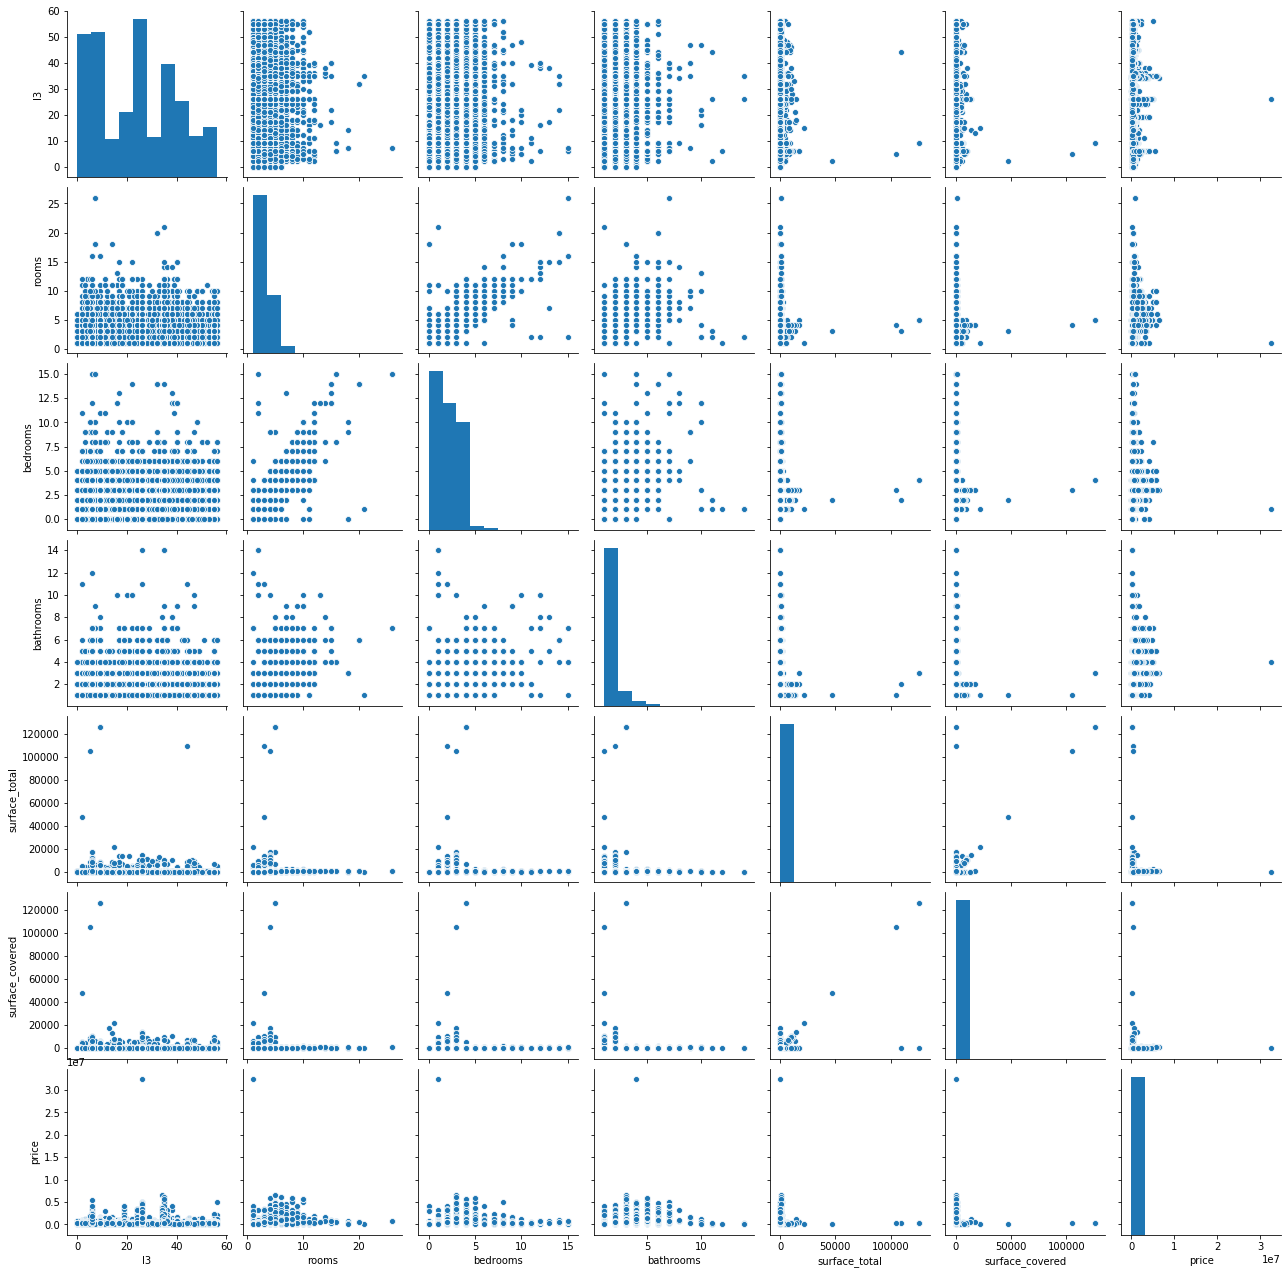

In [14]:
sns.pairplot(properatiEncoded.drop(['property_Casa','property_Departamento','property_PH'],axis=1))

In [15]:
variables = ['bathrooms','bedrooms','rooms','surface_total','surface_covered','price']
properatiNoOutliers = properatiEncoded.copy()

# Limit the data to values between +- 3 standard deviations from the mean. In case the minimum bound is negative, leave it at 0
for i in variables:
    
# In case the minimum bound of the variable is less than 0, truncate it to this value so that it is not negative
    if properatiEncoded[i].mean() - 3*properatiEncoded[i].std() <0:
        minimum = 0
        maximum = properatiEncoded[i].mean() + 3*properatiEncoded[i].std()
        properatiNoOutliers = properatiNoOutliers[(properatiNoOutliers[i]>minimum)&(properatiNoOutliers[i]<maximum)|(properatiNoOutliers[i]==np.NaN)]

# In case the minimum bound of the variable is greater than 0, it is calculated in the same way as the maximum bound
    else:
        minimum = properatiEncoded[i].mean() - 3*properatiEncoded[i].std()
        maximum = properatiEncoded[i].mean() + 3*properatiEncoded[i].std()
        properatiNoOutliers = properatiNoOutliers[(properatiNoOutliers[i]>minimum)&(properatiNoOutliers[i]<maximum)|(properatiNoOutliers[i]==np.NaN)]
    print("Variable",str(i),": Average: "+str(properatiEncoded[i].mean()),"STD: ",properatiEncoded[i].std(),"; Min value:",str(minimum),";Max value: ",str(maximum))

Variable bathrooms : Average: 1.5514893151882823 STD:  0.8540381716810768 ; Min value: 0 ;Max value:  4.113603830231513
Variable bedrooms : Average: 1.960277641143357 STD:  1.0729463462652755 ; Min value: 0 ;Max value:  5.179116679939184
Variable rooms : Average: 2.9642782969885775 STD:  1.3147042162697156 ; Min value: 0 ;Max value:  6.9083909457977235
Variable surface_total : Average: 107.99392250095644 STD:  931.8860341324178 ; Min value: 0 ;Max value:  2903.6520248982097
Variable surface_covered : Average: 91.97364595288845 STD:  738.342680226091 ; Min value: 0 ;Max value:  2307.0016866311616
Variable price : Average: 259500.25823905558 STD:  322265.44079864526 ; Min value: 0 ;Max value:  1226296.5806349914


The effect of the mask applied in the modification of the pairplot with respect to the one previously plotted is evident

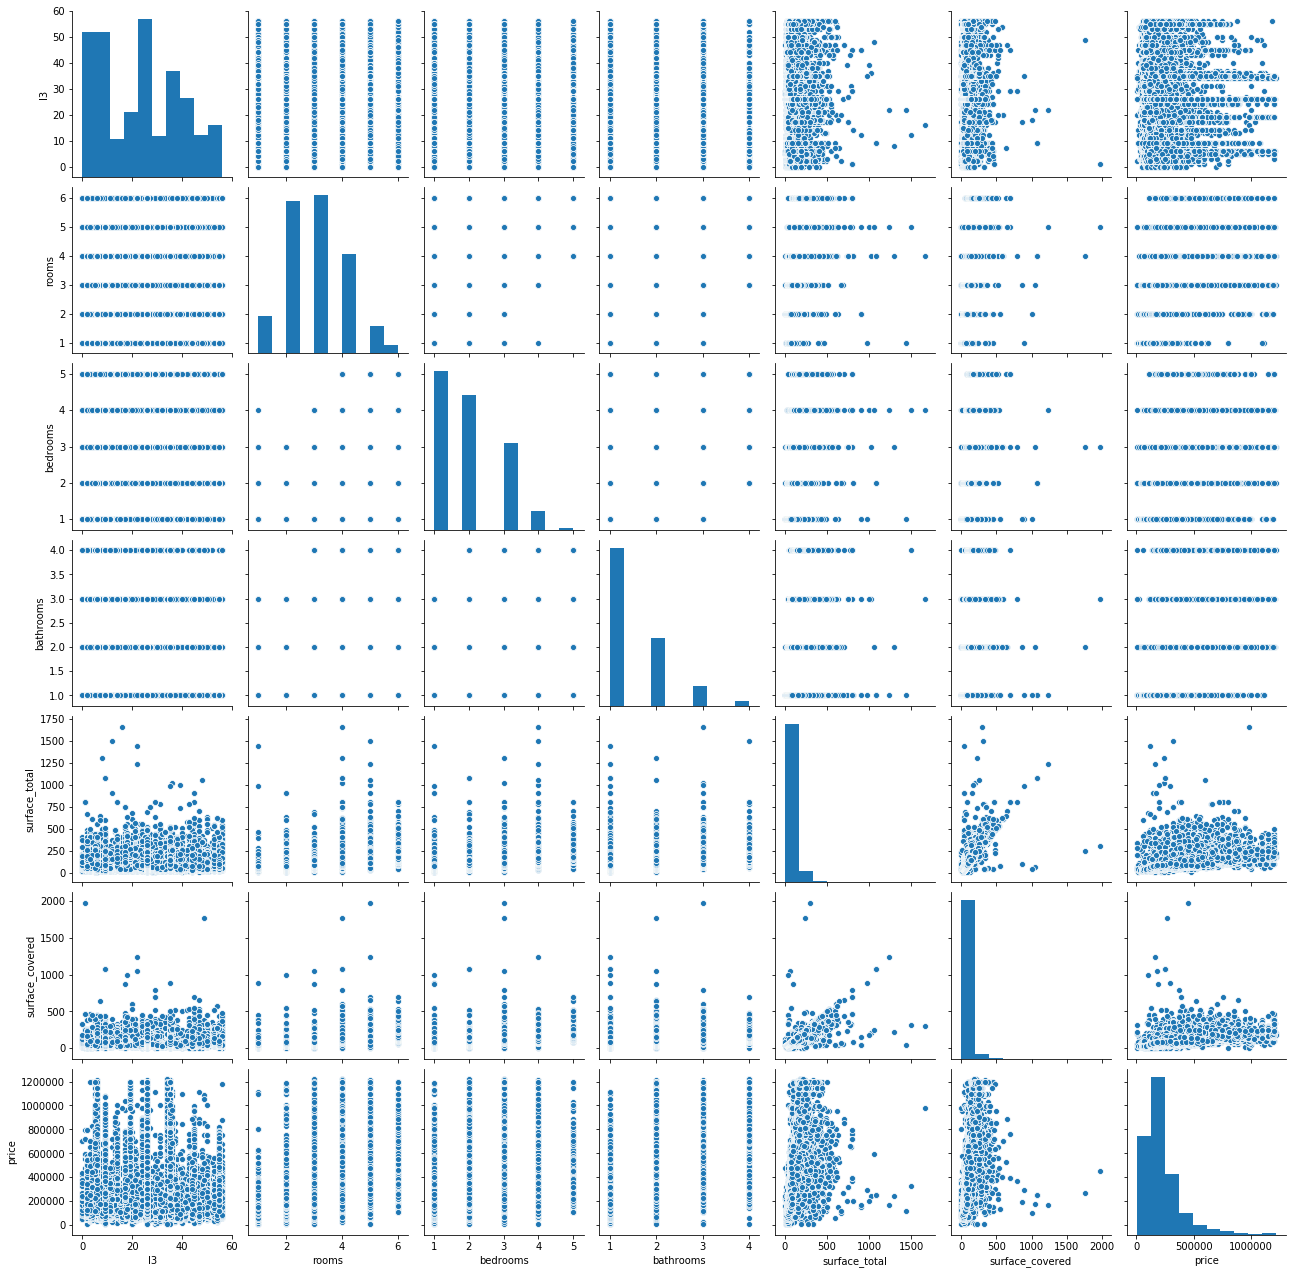

In [16]:
sns.pairplot(properatiNoOutliers.drop(['property_Casa','property_Departamento','property_PH'],axis=1))

## Data scaling

To select the scaling method, the distributions of the 6 variables will be plotted first:

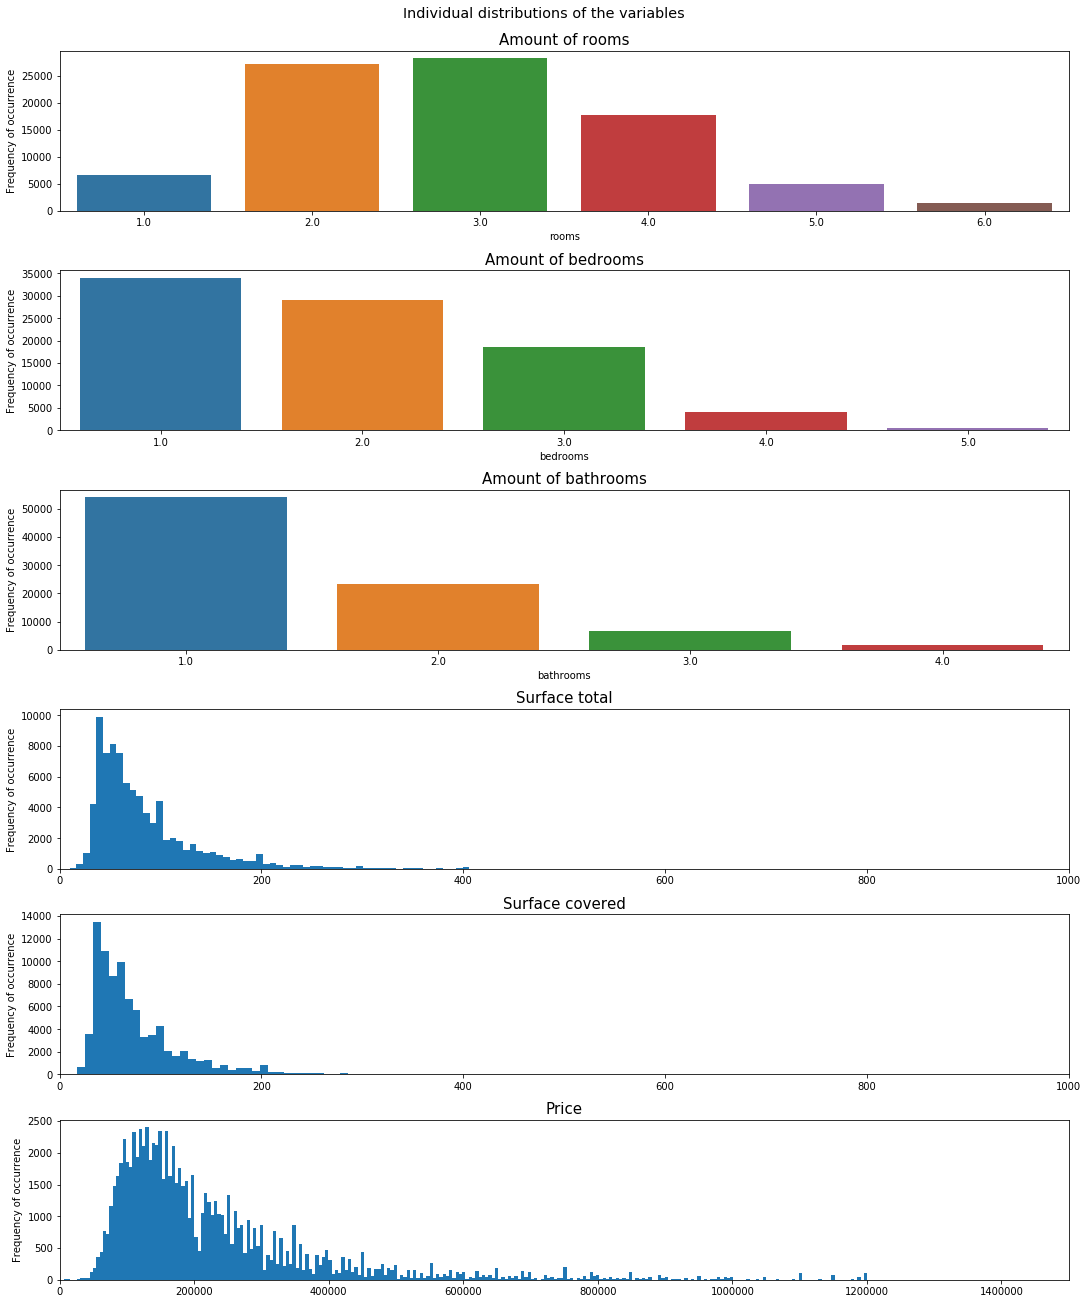

In [17]:
fig, axes = plt.subplots(6, 1, figsize=(15,18), constrained_layout=True)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

sns.countplot(properatiNoOutliers["rooms"],
              ax=ax1)
ax1.set_ylabel('Frequency of occurrence')
ax1.set_title("Amount of rooms", fontdict={"fontsize":15})

sns.countplot(properatiNoOutliers["bedrooms"],
              ax=ax2)
ax2.set_ylabel('Frequency of occurrence')
ax2.set_title("Amount of bedrooms", fontdict={"fontsize":15})


sns.countplot(properatiNoOutliers["bathrooms"],
              ax=ax3)
ax3.set_ylabel('Frequency of occurrence')
ax3.set_title("Amount of bathrooms", fontdict={"fontsize":15})

ax4.hist(properatiNoOutliers["surface_total"],
              bins=250)
ax4.set_xlim(0,1000)
ax4.set_ylabel('Frequency of occurrence')
ax4.set_title("Surface total", fontdict={"fontsize":15})

ax5.hist(properatiNoOutliers["surface_covered"],
              bins=250)
ax5.set_xlim(0,1000)
ax5.set_ylabel('Frequency of occurrence')
ax5.set_title("Surface covered", fontdict={"fontsize":15})

ax6.hist(properatiNoOutliers["price"],
              bins=250)
ax6.set_xlim(0,1500000)
ax6.set_ylabel('Frequency of occurrence')
ax6.set_title("Price", fontdict={"fontsize":15})
ax6.ticklabel_format(style='plain')


fig.suptitle("Individual distributions of the variables", size= "x-large")
plt.show()

Taking into account the shapes of the distributions of the previous dataset, we can observe:
- The `rooms` attribute **(number of rooms)** has a normal distribution
- The `surface_total` attribute **(total surface)** has a logarithmic distribution
- The `surface_covered` attribute **(covered surface)** has a logarithmic distribution
- The `price` attribute **(price)** has a logarithmic distribution

For attributes with normal distribution, we will apply a `Z-score` transformation, while for those with a logarithmic distribution we will apply a `logarithmic` transformation

Transformation: Z-score
Attribute: rooms


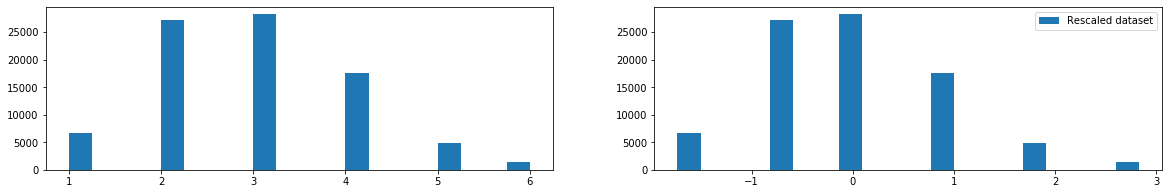

Attribute: bathrooms


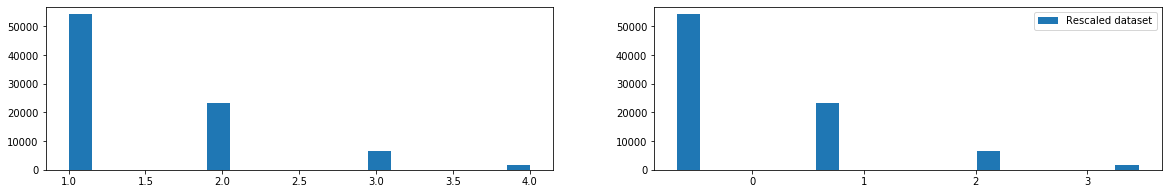

Attribute: bedrooms


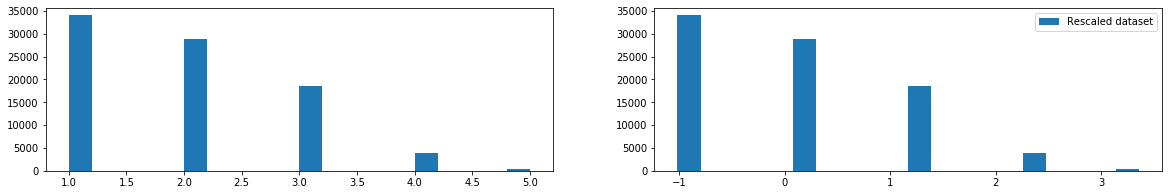

Transformation: logarithmic
Attribute: surface_total


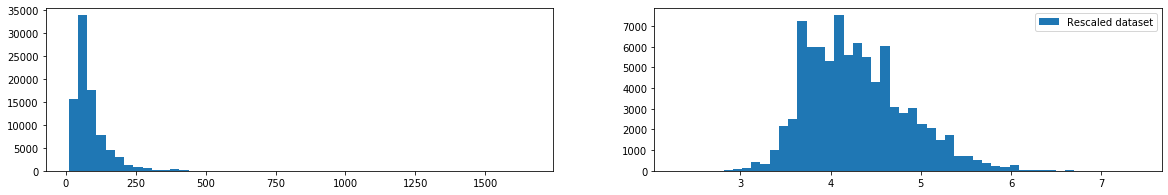

Attribute: surface_covered


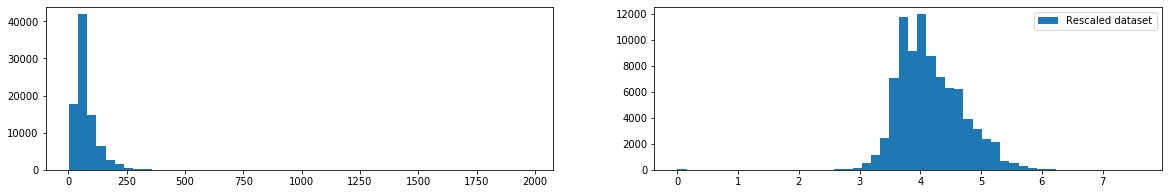

Attribute: price


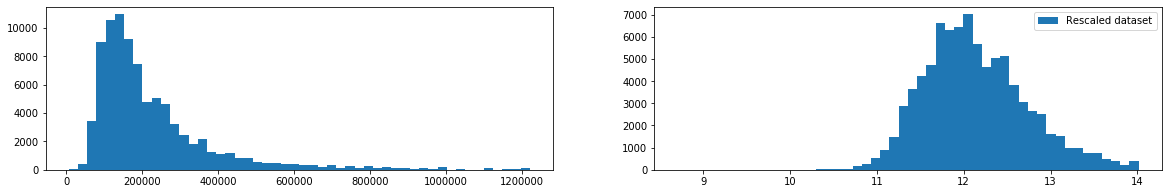

In [18]:
from sklearn.preprocessing import scale
dataset_transformed= properatiNoOutliers.copy()

# Z-Score transformation

attributes = ['rooms', 'bathrooms','bedrooms']
print('Transformation: Z-score')

for i,column in enumerate(attributes):
    attribute = attributes[i]
    print(f'Attribute: {attribute}')
    
    average_value = dataset_transformed[attribute].mean()
    std = dataset_transformed[attribute].std()
    dataset_transformed[attribute] = (dataset_transformed[attribute] - average_value)/std
    fig, [ax, ax1] = plt.subplots(nrows = 1,ncols = 2,figsize=(20,3)) 
    ax.hist(properatiNoOutliers[attribute],label = 'Dataset without transformation',bins=20)
    ax1.hist(dataset_transformed[attribute],label = 'Rescaled dataset',bins=20)
    plt.legend()
    plt.show()


# Log transformation

attributes = ['surface_total', 'surface_covered','price']
print('Transformation: logarithmic')
for i,column in enumerate(attributes):
    attribute = attributes[i]
    print(f'Attribute: {attribute}')
    
    # Apply log transformation
    dataset_transformed[attribute] = np.log(dataset_transformed[attribute])
    
    fig, [ax, ax1] = plt.subplots(nrows = 1,ncols = 2,figsize=(20,3)) 
    
    ax.hist(properatiNoOutliers[attribute],label = 'Dataset without transformation',bins=50)
    ax1.hist(dataset_transformed[attribute],label = 'Rescaled dataset',bins=50)
    
    plt.legend()
    plt.show()

We can see that the normalized variables have similar distributions, allowing them to be subsequently compared in a Machine Learning model.

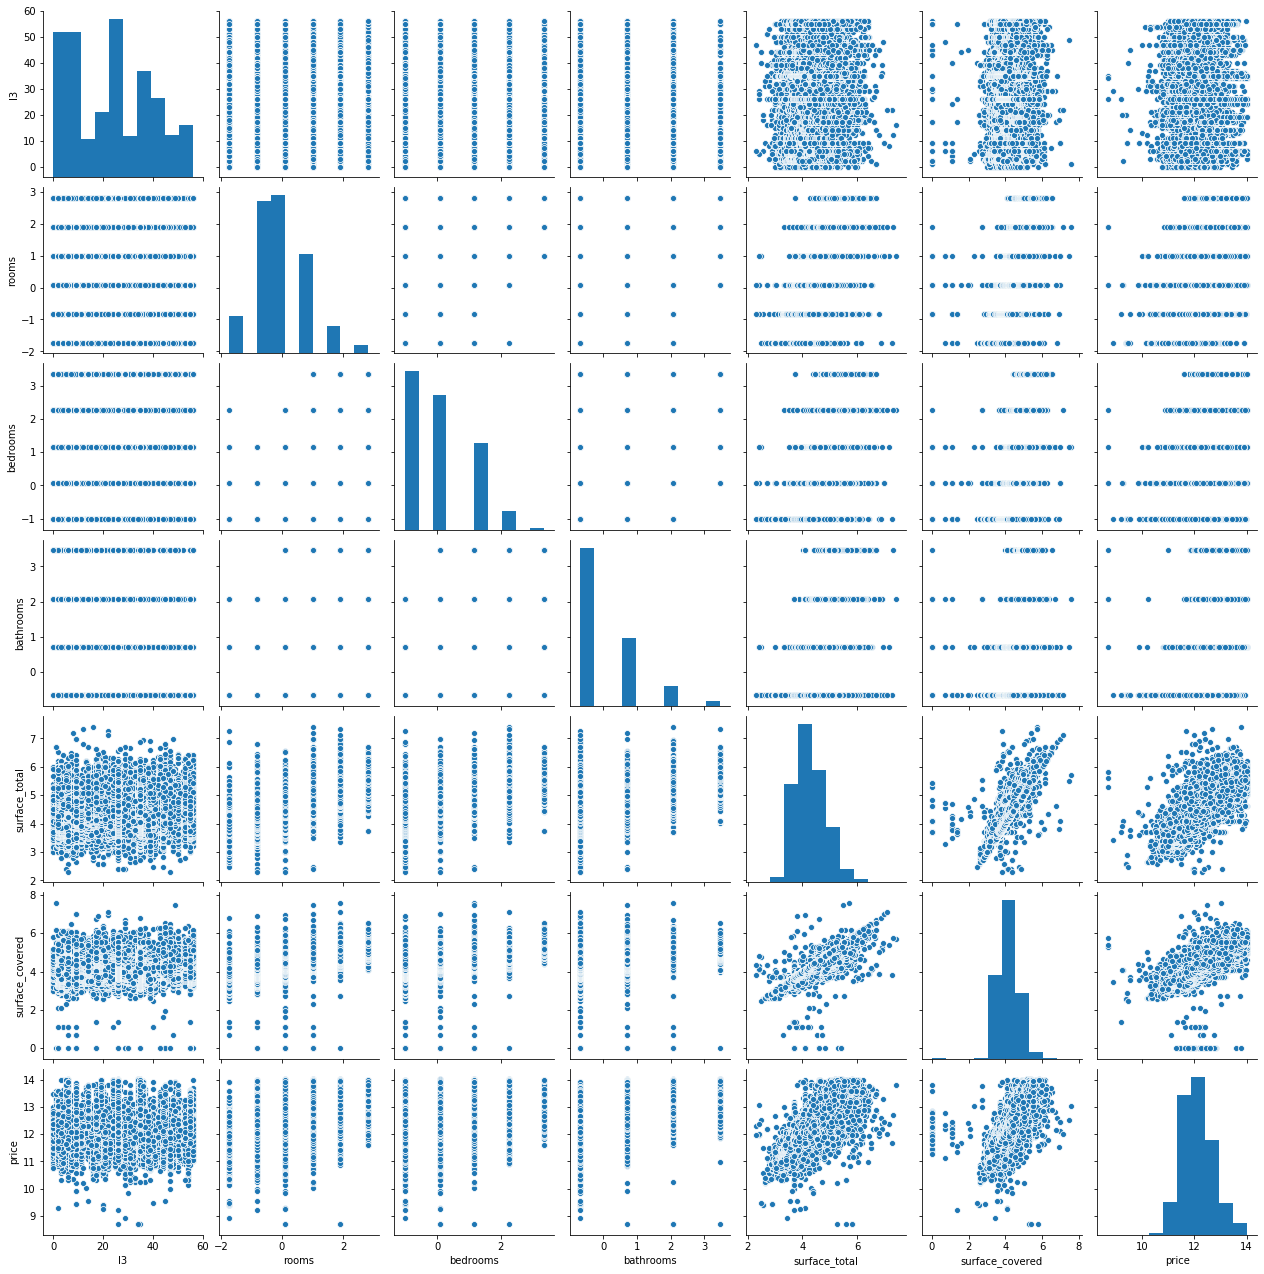

In [19]:
sns.pairplot(dataset_transformed.drop(['property_Casa','property_Departamento','property_PH'],axis=1))

## Recap: iteration I model

Next, I will retrain and predict again the *iteration I* model to demonstrate its performance in order to be able to compare it with the model developed after the preprocessing proposed in this report. We can see that after training it, the minimum RMSE (for `k = 22` and `decision tree`) will be **`$134.911`**

In [20]:
# Load dataset
properati = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')

# Filter property_type: condominium ('PH'), apartment ('Departamento') or house ('Casa') located in Capital Federal 
filtered = properati[properati.property_type.isin(['PH','Departamento','Casa'])& properati.l2.isin(['Capital Federal'])]

# Filter properties with surface_total over 15 and less than 1000
filtered = filtered[(filtered['surface_total'] >= 15) & (filtered['surface_total'] <= 1000)]

# Filter properties with price less than $4.000.000
filtered = filtered[(filtered['price'] <= 4000000)]

# Drop attributes that are not amount of rooms, bedrooms, bathrooms, total area, covered area and price
filtered = filtered.drop(columns=['lat','lon','start_date','end_date','created_on','l1','l2','l3','currency','title','description','operation_type','property_type'])

# Drop instances with missing values
filtered = filtered.dropna(axis=0)

# Select predictor variables and variable to predict
X = filtered.drop(columns= ['price'])
y = filtered['price']

# Perform train/test/split 70-30%
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = 5)

# Select regression model that had the lowest error (decision tree) and the previously optimized hyperparameter (k = 22)
tree_regressor = DecisionTreeRegressor(max_depth=22,random_state=42)

# Train model
tree_regressor.fit(X_train, y_train)

# Perform prediction for test set
y_test_pred = tree_regressor.predict(X_test)

# Calculate RMSE
rmse_accTest_no_preprocessing = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Print result
print('Min RMSE in test set of '+"${:,.2f}". format(rmse_accTest_no_preprocessing))

Min RMSE in test set of $134,911.47


Recalculate k for the dataset with the proposed preprocessing

In [21]:
# Load dataset
filtered = dataset_transformed.copy()

# Select predictor variables and variable to predict
X = filtered.drop(columns= ['price'])
y = filtered['price']

# Perform train/test/split 70-30%
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = 5)

# Set empty list for desired accuracy values
rmse_accuracy_test_preprocessed = []

# Set list of values of tree depth
max_depths = np.arange(1,35)

# Loop over different depth values 
for max_depth in max_depths:
    global RMSE_preprocessed
    # Set max depth value for the model
    rgrT = DecisionTreeRegressor(max_depth = max_depth, random_state=42)
    
    # Train
    rgrT.fit(X_train,y_train)
        
    # Test over test dataset and rescale
    y_test_pred = rgrT.predict(X_test)
    rmse_accTest_preprocessed = np.sqrt(mean_squared_error(np.exp(y_test),np.exp(y_test_pred)))
    
    # Append accuracy to a list
    rmse_accuracy_test_preprocessed.append(rmse_accTest_preprocessed)
    
    # Get best accuracy from list
    rmse_dt_min = min(rmse_accuracy_test_preprocessed)
    dt_min = rmse_accuracy_test_preprocessed.index(min(rmse_accuracy_test_preprocessed))+1

print('Min RMSE in test of '+"${:,.2f}". format(rmse_accTest_preprocessed.min()),
      ', corresponding to depth k = ',
     f"{rmse_accuracy_test_preprocessed.index(min(rmse_accuracy_test_preprocessed))+1}")

Min RMSE in test of $69,303.73 , corresponding to depth k =  20


In [22]:
error_reduction = "{1:.{0}f}%".format(2,min(rmse_accuracy_test_preprocessed)/rmse_accTest_no_preprocessing*100)
print('Error reduction with proposed preprocessing is '+ error_reduction)

Error reduction with proposed preprocessing is 50.97%


# Conclusion

The proposed preprocessing of the dataset reduces the RMSE by **50.97%**, which is a significant improvement, although still far from a value that can be used outside the experimental setting.

# Part B - Advanced models

For this section I will use 6 different Machine Learning models in order to compare their performance with each other and with the previously exposed model, optimizing their hyperparameters through Cross Validation and Grid Search or Random Search.

In [23]:
tree = DecisionTreeRegressor()
bagging = BaggingRegressor()
forest = RandomForestRegressor()
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=250)
linear_model = LinearRegression()

## Model training
### `Decision tree` optimized with `RandomSearchCV`

In [24]:
param_tree = {"criterion": ["mse", "friedman_mse"],
             "max_depth": sp.stats.randint(2, 20),
             "min_samples_split": sp.stats.randint(2, 20)}

tree_opt = RandomizedSearchCV(tree, param_tree, n_iter=150, random_state=30, cv=5)
tree_opt.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=None,
                                                   splitter='best'),
                   iid='d

### `XGBRegressor`

In [25]:
xgb_model = XGBRegressor(objective="reg:squarederror")
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### `XGBRegressor` optimized with `RandomSearchCV`

In [26]:
parameters = {
        'num_boost_round': [10, 25, 50],
        'eta': [0.05, 0.1, 0.3],
        'max_depth': [3, 4, 5],
        'subsample': [0.9, 1.0],
        'colsample_bytree': [0.9, 1.0],
    }

xgb_model_opt = XGBRegressor(objective ='reg:squarederror')

xgb_model_opt = RandomizedSearchCV(xgb_model_opt, parameters, cv=5)

xgb_model_opt.fit(X_train,y_train)

[15:56:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:56:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:56:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only u

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validat

### `RandomForestRegressor`

In [27]:
forest = RandomForestRegressor(n_estimators=1000, 
                             max_features="sqrt", 
                             n_jobs=-1, 
                             oob_score = False, 
                             random_state = 42)

forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

### `RandomForest` optimized with `RandomSearchCV`

In [28]:
random_rf = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230]}

rf_random = RandomizedSearchCV(RandomForestRegressor(), 
       param_distributions = random_rf, 
       n_iter = 10, 
       cv = 3, 
       n_jobs = -1)

rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

### `AdaBoost` optimized with `RandomSearchCV`

In [29]:
param_ada = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }

adaboost = RandomizedSearchCV(AdaBoostRegressor(),
 param_distributions = param_ada,
 cv=3,
 n_iter = 10,
 n_jobs=-1)

adaboost.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=AdaBoostRegressor(base_estimator=None,
                                               learning_rate=1.0, loss='linear',
                                               n_estimators=50,
                                               random_state=None),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.3,
                                                          1],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [50, 100]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

### `Polinomial regression`

In [30]:
linear = LinearRegression()

linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Calculation of RMSE for each one

Set function to see more easily the differences in errors yielded between the models with and without preprocessing

In [31]:
def RMSE(names_models,list_models, X_train, X_test,y_train,y_test):
    print("------------------------------------------")
    print(f'Model: decision tree with preprocessing')
    print(f'RMSE preprocessed model in Test: USD {round(rmse_accTest_preprocessed,2)}')
    print(f'RMSE non-preprocessed model in Test: USD {round(rmse_accTest_no_preprocessing,2)}')

    for i, model in enumerate(list_models):
        y_test_pred = model.predict(X_test)
        print("------------------------------------------")
        print(f'Model: {names_models[i]}')
        rmse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_test_pred)))
        reduction_error_preprocessed = "{1:.{0}f}%".format(2,-((rmse_test/min(rmse_accuracy_test_preprocessed))-1)*100)
        reduction_error_no_preprocessing = "{1:.{0}f}%".format(2,-((rmse_test/rmse_accTest_no_preprocessing)-1)*100)
        print(f'RMSE in Test: USD {round(rmse_test,2)}')
        print('Error reduction with respect to the model with preprocessing is of '+reduction_error_preprocessed)
        print('Error reduction with respect to the model without preprocessing is of '+reduction_error_no_preprocessing)

Call the above function and pass parameters

In [32]:
models = ['DecisionTreeRegressor + RandomSearchCV','XGBRegressor','XGBoost + RandomSearchCV','RandomForest','RandomForest + RandomSearchCV','AdaBoost optimizado con RandomSearchCV','Polinomial Regression']

list_models = [tree_opt,xgb_model,xgb_model_opt,forest,rf_random,adaboost,linear]
RMSE(models, list_models,X_train, X_test, y_train, y_test)

------------------------------------------
Model: decision tree with preprocessing
RMSE preprocessed model in Test: USD 69303.73
RMSE non-preprocessed model in Test: USD 134911.47
------------------------------------------
Model: DecisionTreeRegressor + RandomSearchCV
RMSE in Test: USD 68355.89
Error reduction with respect to the model with preprocessing is of 0.58%
Error reduction with respect to the model without preprocessing is of 49.33%
------------------------------------------
Model: XGBRegressor
RMSE in Test: USD 65363.34
Error reduction with respect to the model with preprocessing is of 4.94%
Error reduction with respect to the model without preprocessing is of 51.55%
------------------------------------------
Model: XGBoost + RandomSearchCV
RMSE in Test: USD 67868.49
Error reduction with respect to the model with preprocessing is of 1.29%
Error reduction with respect to the model without preprocessing is of 49.69%
------------------------------------------
Model: RandomForest

We can observe from the results presented above that the best performing model is the **Random Forest**, which reduces the mean square error by **56.18%** with respect to the best model (**decision tree**) of Project 01, and in a **14.03%** with respect to the same model with pre-processing of this report.

In any case, as we can see below, the value of the best RMSE obtained is still high.

In [33]:
y_test_pred = forest.predict(X_test)
rmse_test_forest = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_test_pred)))
min_numbers_RMSE = properati[properati["price"]<=2*rmse_test_forest].count()["price"]
num_instances = properati["price"].count()

# Calculo la proporción de instancias en donde 1/3 del valor de la propiedad supere el RMSE
properties_rate = min_numbers_RMSE/num_instances
print(f'RMSE value represents half the value of '+"{1:.{0}f}%".format(2,properties_rate*100)+' of total properties')

RMSE value represents half the value of 27.85% of total properties


# Part C - Interpretation of data

I will then plot the importance of each variable in 2 randomly obtained decision trees

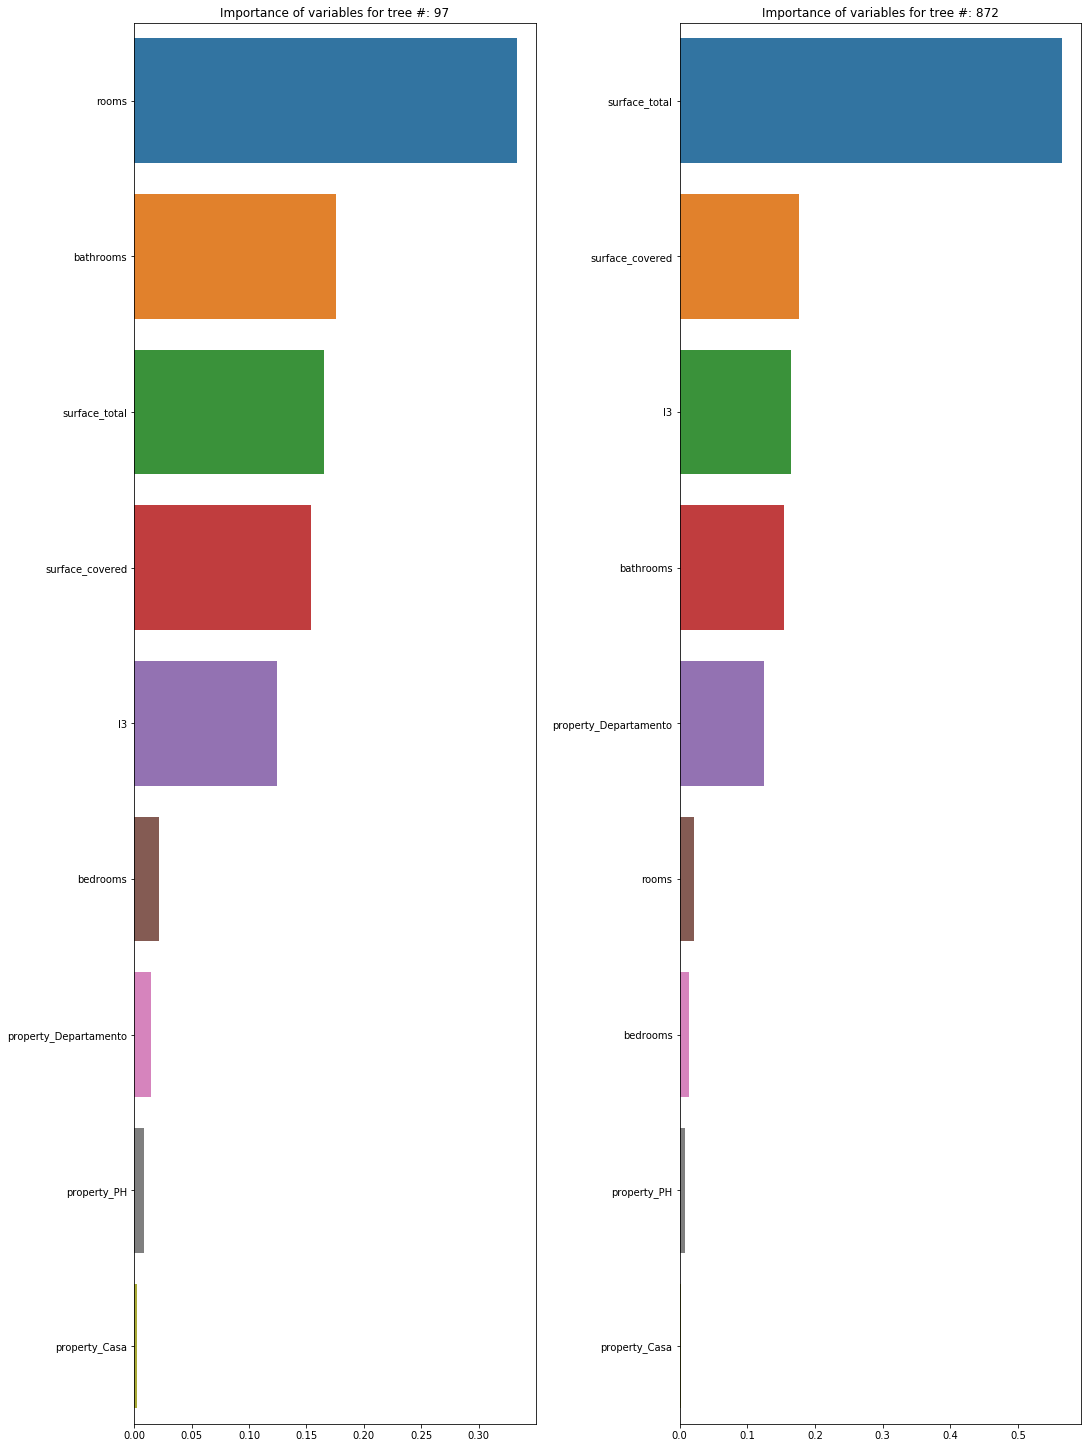

In [50]:
fig, axes = plt.subplots(1,2,figsize=(15,20), constrained_layout=True)
ax1, ax2 = axes.flatten()  

lista_arboles = np.random.randint(low=1,high=999, size=2)

importances = forest.estimators_[lista_arboles[0]].feature_importances_
columns = X_train.columns
indices = np.argsort(importances)[::-1]

sns.barplot(y=columns[indices], x=importances[indices])
g1 = sns.barplot(y=columns[indices], x=importances[indices],ax = ax1)
g1.set(title= "Importance of variables for tree #: " +str(lista_arboles[0]))

importances = forest.estimators_[lista_arboles[1]].feature_importances_
columns = X_train.columns
indices = np.argsort(importances)[::-1]

sns.barplot(y=columns[indices], x=importances[indices])
g2 = sns.barplot(y=columns[indices], x=importances[indices],ax = ax2)
g2.set(title= "Importance of variables for tree #: " +str(lista_arboles[1]))
  
plt.show()

Different random trees yield different importances of the attributes in the determination of the price.

This is because the model, for each simulation, generates a new instance that corresponds to a subset of the training set with a subset of the attributes. Each tree will be unique and will consider a part of the variables. This is why both charts end up being different.

The difference in importance between the total and covered area in both trees when both variables strongly correlate with each other and with the price is worthy of notice. It would be expected for them to have a similar importance.

In any case, it is logic that the attributes associated with the surface of the properties are weighted as one of the most important predictors of price, although perhaps the influence of the neighborhood to which they belong should be stronger.

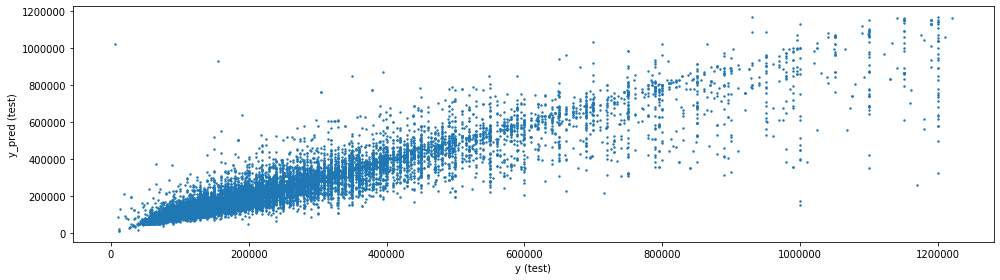

In [47]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_train_pred)))
rmse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_test_pred)))

plt.figure(figsize = (14,4))
plt.scatter(np.exp(y_test),np.exp(y_test_pred), s =2)
    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
plt.ticklabel_format(style='plain')


plt.tight_layout()
plt.show()

As a last conclusion and observing the previous plot, it can be seen that the model follows a linear pattern for properties of lower value (ideally less than **USD 200,000**), which means that the prediction value resembles to a greater extent to the training set.

As we see the value of the property grow, the dispersion of the plot also grows, and therefore the error when predicting the price

The greater dispersion could be attributed to:
- Factors not taken into account that affect expensive properties to a greater extent (existence or not of swimming pool, multipurpose room, private security, better finishes, etc)

- Lack of data for properties with these high values, fitting the best model to properties with a price similar to most of the dataset instances

# Conclusions

- As expected the proposed improvements, both preprocessing and the use of better predictive models in this report, significantly improved performance compared to Iteration I. Adding variables such as neighborhood, reducing noise from outliers, scaling variables or not discarding so many instances just because they have missing values greatly enriched the model.

- However, as in the previous report, the mean square error of the best model (**USD 59,113**) is still significant and unacceptable considering that it is half the value of 27% of the apartments for sale.

- There is more room for model improvements:
    - Data external to the dataset could be used such as the location of some points of interest (such as subway stations, hospitals, schools or bus stops) relative to the properties using the coordinates.
    - As a future improvement of the dataset and taking into account that the pricing of a property (and more so in a real estate market such as Argentina) can present large variations in a short period of time, a binary (yes/no) variable "realization of the operation of sale" could be added. This categorical variable would be easy to collect, and at the same time penalize excessively high prices when the property hasn't been sold, resulting in an improvement in the predictive capacity of the model.